# Specific game attributes for SIL test

In [49]:
%pylab inline
import scipy.stats as stats
import itertools
import pandas as pd
import networkx as nx
from lifelines import CoxTimeVaryingFitter
import json
from collections import Counter
from measure_experiment import *

import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


In [64]:
export_dir = "../../results-anonymized/SIL_test/CoxBots/"
players = []
with open(export_dir + 'players.jsonl', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.jsonl', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.jsonl', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.jsonl', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'], game['gameSetupId'])

0 2020-05-28T18:12:48.522Z panel_0_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
1 2020-05-28T18:20:53.159Z panel_1_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2 2020-05-28T18:32:58.037Z panel_2_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
3 2020-05-28T18:48:35.754Z panel_4_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
4 2020-05-28T19:04:15.831Z panel_5_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
5 2020-05-28T19:12:33.965Z panel_6_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
6 2020-05-28T19:20:44.823Z panel_7_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
7 2020-05-28T19:40:30.187Z panel_8_matched_pair_exp_design6_matched_bots_20200521_115420_allBots


In [79]:
# select which games to process
# Game 1 was a test game, for practice

select = [2]
process_games = [loaded_games[i] for i in select]
for game in process_games:
    print(i, game['createdAt'], game['gameSetupId'])

7 2020-05-28T18:32:58.037Z panel_2_matched_pair_exp_design6_matched_bots_20200521_115420_allBots


In [80]:
for player_id, player in game['players'].items():
    if 'workerId' in player['urlParams'].keys():
        player['name'] = player['urlParams']['workerId']
    else:
        player['name'] = player['id']

In [81]:
t_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='t']
c_players = [pid for pid in list(game['players'].keys()) if game['players'][pid]['data.position'][0]=='c']

In [82]:
t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

game_log = pd.DataFrame(game['log'])
game_log['logTime'] = game_log['createdAt'].apply(lambda s: datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ'))
game_log['t'] = game_log['logTime'] - t_start
game_log

,_id,playerId,gameId,roundId,stageId,name,jsonData,createdAt,data,logTime,t
0,FgeP42irpNyp2biMx,WKRYZD3P6EWnf6h5i,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""cclue_5_12"",""source"":"""",""dest"":""promi...",2020-05-28T18:33:14.674Z,"{'clue': 'cclue_5_12', 'source': '', 'dest': '...",2020-05-28 18:33:14.674,00:00:16.637000
1,6hc4EFJB3RvCdyZen,PExP7YYAEjbGHP8Jx,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""tclue_4_13"",""source"":"""",""dest"":""promi...",2020-05-28T18:33:17.533Z,"{'clue': 'tclue_4_13', 'source': '', 'dest': '...",2020-05-28 18:33:17.533,00:00:19.496000
2,9vwWXsnxeMDcMctNA,kBJdJfFRYjuciXgZF,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""tclue_3_11"",""source"":"""",""dest"":""dead_...",2020-05-28T18:33:17.650Z,"{'clue': 'tclue_3_11', 'source': '', 'dest': '...",2020-05-28 18:33:17.650,00:00:19.613000
3,3CWWEehhb2QnnFtMk,8cW7pKaMedQDGvmH5,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""cclue_2_6"",""source"":"""",""dest"":""promis...",2020-05-28T18:33:18.811Z,"{'clue': 'cclue_2_6', 'source': '', 'dest': 'p...",2020-05-28 18:33:18.811,00:00:20.774000
4,9HHDig7GnDC9pQ3ei,opRZTQAAzMni3HtHF,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""cclue_1_9"",""source"":"""",""dest"":""promis...",2020-05-28T18:33:19.234Z,"{'clue': 'cclue_1_9', 'source': '', 'dest': 'p...",2020-05-28 18:33:19.234,00:00:21.197000
...,...,...,...,...,...,...,...,...,...,...,...
970,QLDcnYNZQ7iTpf7gv,QcsFs6YRPBwa2fDy6,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""tclue_4_6"",""source"":"""",""dest"":""promis...",2020-05-28T18:40:56.652Z,"{'clue': 'tclue_4_6', 'source': '', 'dest': 'p...",2020-05-28 18:40:56.652,00:07:58.615000
971,sj9uwhYBJJt4iYvuy,PExP7YYAEjbGHP8Jx,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""tclue_2_8"",""source"":"""",""dest"":""dead_e...",2020-05-28T18:40:57.873Z,"{'clue': 'tclue_2_8', 'source': '', 'dest': 'd...",2020-05-28 18:40:57.873,00:07:59.836000
972,ZQRqvJzmpJDKviY3v,vSGpAGmevZHztcwXn,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""tclue_10_11"",""source"":"""",""dest"":""prom...",2020-05-28T18:40:57.922Z,"{'clue': 'tclue_10_11', 'source': '', 'dest': ...",2020-05-28 18:40:57.922,00:07:59.885000
973,Y5mb53jTCEcbMfFcp,A92378zS3LFJ6DEGf,gtZ9uDFFZxv3JsQZi,rXTKbpkKMs33efJMe,YrTchKmTuKTLXvAtG,drop,"{""clue"":""tclue_1_3"",""source"":"""",""dest"":""promis...",2020-05-28T18:40:58.336Z,"{'clue': 'tclue_1_3', 'source': '', 'dest': 'p...",2020-05-28 18:40:58.336,00:08:00.299000


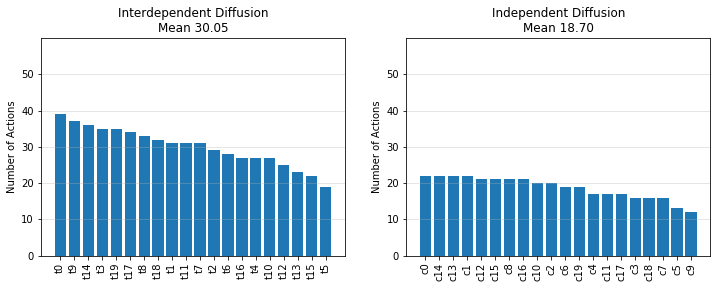

In [83]:
plt.figure(figsize=(12,4))

counts = game_log[game_log['name'] == 'drop'][['playerId', '_id']].groupby('playerId').count()

log_length = {}
for pid in t_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,1)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Interdependent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

log_length = {}
for pid in c_players:
    player = game['players'][pid]
    if pid in counts.index:
        log_length[player['data.position']] = counts.loc[pid].values[0]
    else:
        log_length[player['data.position']] = 0
        
order = list(reversed(sorted(log_length.keys(), key=lambda x: log_length[x]))) 
plt.subplot(1,2,2)
plt.bar(order, [log_length[x] for x in order])
plt.xticks(rotation=90);
plt.ylim(0,60)
plt.yticks(range(0,60,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Number of Actions')
plt.title('Independent Diffusion\nMean %.02f' % (np.mean(list(log_length.values()))));

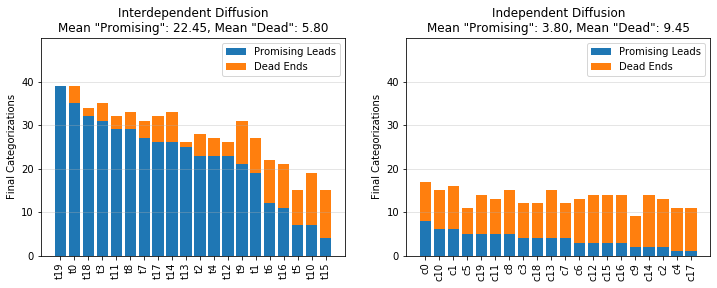

In [84]:
plt.figure(figsize=(12,4))

promising = {}
dead = {}
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,1)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Interdependent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));


promising = {}
dead = {}
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        promising[player['data.position']] = len(player['data.notebooks']['promising_leads']['clueIDs'])
        dead[player['data.position']] = len(player['data.notebooks']['dead_ends']['clueIDs'])
    else:
        promising[player['data.position']] = 0
        dead[player['data.position']] = 0
        
order = list(reversed(sorted(promising.keys(), key=lambda x: promising[x])))
plt.subplot(1,2,2)
plt.bar(order, [promising[k] for k in order], label='Promising Leads')
plt.bar(order, [dead[k] for k in order], bottom=[promising[k] for k in order], label='Dead Ends')
plt.legend()
plt.xticks(rotation=90);
plt.ylim(0,50)
plt.yticks(range(0,50,10));
plt.grid('on', axis='y', alpha=.4)
plt.ylabel('Final Categorizations')
plt.title('Independent Diffusion\nMean "Promising": %.02f, Mean "Dead": %.02f' %(np.mean(list(promising.values())), np.mean(list(dead.values()))));

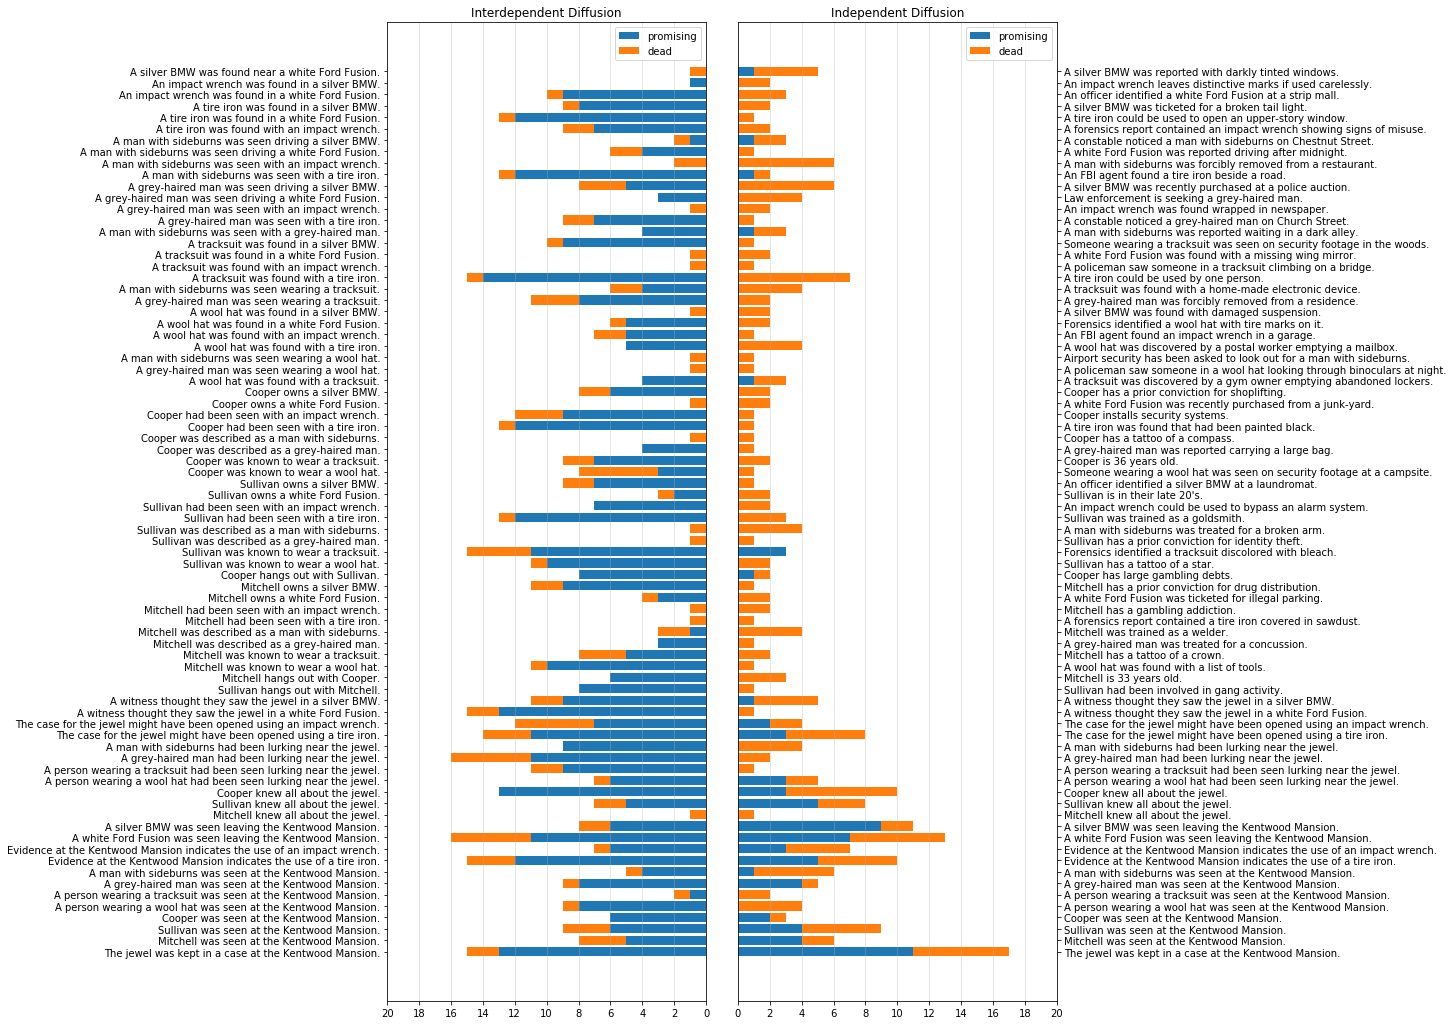

In [85]:

plt.figure(figsize=(12,18))

promising = Counter()
dead = Counter()
for pid in t_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1
            
axl = plt.subplot(1,2,1)       
#order = list(set(promising.keys()).union(set(dead.keys())))
order = [k for k in game['data.clues'].keys() if k[0]=='t']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
        [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.box('off')
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.grid('on', axis='x', alpha=.4)
plt.title('Interdependent Diffusion');
axl.invert_xaxis()
inter_promising = promising
inter_order = order

promising = Counter()
dead = Counter()
for pid in c_players:
    player = game['players'][pid]
    if 'data.notebooks' in player.keys():
        for clue_id in player['data.notebooks']['promising_leads']['clueIDs']:
            promising[clue_id] += 1
        for clue_id in player['data.notebooks']['dead_ends']['clueIDs']:
            dead[clue_id] += 1

axr = plt.subplot(1,2,2)       
order = [k for k in game['data.clues'].keys() if k[0]=='c']
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [promising[k] for k in order], label='promising')
plt.barh([game['data.clues'][clid]['content'] for clid in order], 
         [dead[k] for k in order], left=[promising[k] for k in order], label='dead')
plt.legend()
plt.xlim(0,20)
plt.xticks(range(0,21,2));
plt.box('off')
plt.grid('on', axis='x', alpha=.4)
plt.title('Independent Diffusion');
axr.yaxis.tick_right()
plt.subplots_adjust(wspace=.1)

indep_promising = promising
indep_order = order


In [72]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in inter_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Treatment: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([inter_promising[cl] for cl in spoke])/23, np.sum([inter_promising[cl] for cl in nonspoke])/55))

spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
nonspoke = [key for key in indep_promising.keys() if '_1_' not in key and '_2_' not in key]
print("Control: %.02f adoptions per spoke, %.02f adoptions per nonspoke" % 
      (np.sum([indep_promising[cl] for cl in spoke])/23, np.sum([indep_promising[cl] for cl in nonspoke])/55))

Treatment: 7.26 adoptions per spoke, 4.05 adoptions per nonspoke
Control: 5.35 adoptions per spoke, 0.51 adoptions per nonspoke


3.989782869648269

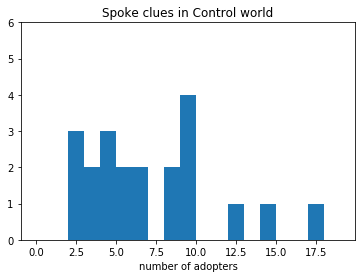

In [31]:
spoke = [key for key in indep_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([indep_promising[cl] for cl in spoke], bins=range(20))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Control world')
#len(spoke)
#sum([indep_promising[cl] for cl in spoke])
np.std([indep_promising[cl] for cl in spoke])

3.8395810020714687

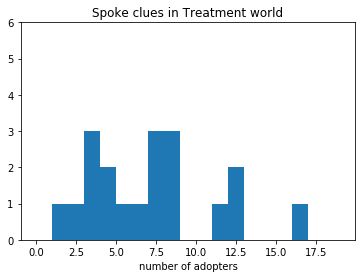

In [32]:
spoke = [key for key in inter_promising.keys() if '_1_' in key or '_2_' in key]
plt.hist([inter_promising[cl] for cl in spoke], bins=range(20))
plt.ylim(0,6)
plt.xlabel("number of adopters")
plt.title('Spoke clues in Treatment world')
#len(spoke)
#sum([inter_promising[cl] for cl in spoke])
np.std([inter_promising[cl] for cl in spoke])

# idle check

In [62]:
activity = {}
for player_id, player in game['players'].items():
    if 'data.active' in player.keys():
        activity[player['data.position']] = player['data.active']

activity


{'t3': 'idle once',
 't10': 'idle once',
 't11': 'idle once',
 'c3': 'idle once',
 'c13': 'idle once',
 't15': 'idle once',
 't9': 'idle once',
 'c19': 'idle once',
 't2': 'idle once',
 't14': 'idle once',
 'c18': 'idle once',
 'c4': 'idle once'}

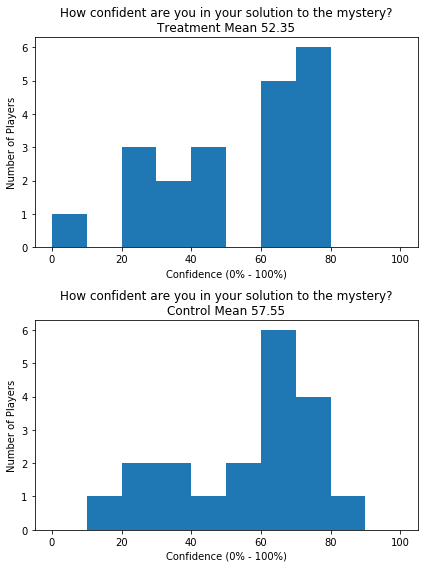

In [59]:
plt.figure(figsize=(6,8))

confidences = []
consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,1)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nTreatment Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)

confidences = []
consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        confidences.append(player['data.caseMade']['confidence'])
plt.subplot(2,1,2)
plt.hist(confidences, bins=range(0,100,10))
np.mean(confidences), np.median(confidences)
plt.xlabel('Confidence (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("How confident are you in your solution to the mystery?\nControl Mean %.02f"%np.mean(confidences))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('confidence.png', transparent=True, dpi=500, bbox_inches='tight')



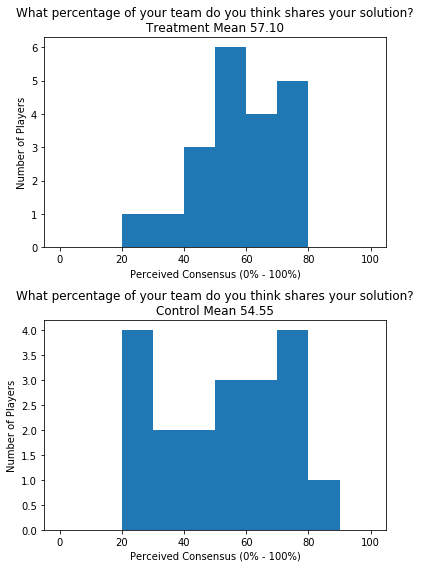

In [60]:
plt.figure(figsize=(6,8))


consensuses = []
for pid in t_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,1)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nTreatment Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)


consensuses = []
for pid in c_players:
    player = game['players'][pid]
    if 'data.caseMade' in player.keys():
        consensuses.append(player['data.caseMade']['consensus'])
plt.subplot(2,1,2)
plt.hist(consensuses, bins=range(0,100,10))
plt.xlabel('Perceived Consensus (0% - 100%)')
plt.ylabel('Number of Players')
plt.title("What percentage of your team do you think shares your solution?\nControl Mean %.02f"%np.mean(consensuses))
plt.xlim(-5,105)
plt.tight_layout()
plt.savefig('consensus.png', transparent=True, dpi=500, bbox_inches='tight')


In [63]:
import string
fair = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'fair' in player['data.survey'].keys():
            s = player['data.survey']['fair']
            fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(fair).value_counts()
pd.DataFrame(counts)


,0
yes,19
very fair,2
fair,1
yes the pay was fair,1
the pay was very fair,1
yes it definitely seems fair,1
i feel the pay was fair,1
pay is very fair,1
extremely fair,1
ok,1


In [64]:
length = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'time' in player['data.survey'].keys():
            s = player['data.survey']['time']
            length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(length).value_counts()
pd.DataFrame(counts)

,0
yes,24
yes i had adequate time to play,1
yeah,1
yes i had enough time,1
almost too much i would say id prefer more time pressure to really force you to concentrate and think fast,1
yes the time was fine,1
it could have been slightly longer maybe but the time given was sufficient to come to a conclussion,1
yes but just barely,1
yes i had enough time to play,1
if anything there was too much time given,1


In [65]:
feedback = []
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'feedback' in player['data.survey'].keys():
            s = player['data.survey']['feedback']
            feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
            
counts = pd.Series(feedback).value_counts()
pd.DataFrame(counts)

,0
,7
no problems,5
na,5
none,3
the rate at which new evidence pops up can be overwhelming and i do not understand the mechanism at which evidence appears,1
i didnt encounter any problems,1
i enjoyed it,1
no issues thanks for the opportunity,1
no problems it was a lot of fun it made me think,1
everything worked as expected,1


In [66]:
for player_id, player in game['players'].items():
    if 'data.survey' in player.keys():
        if 'strategy' in player['data.survey'].keys():
            print('\n', player['data.survey']['strategy'])
            
        


 organized chaos.

 I was a bit more conservative. Only things that seemed to be directly related to the crime.

 i tried to connect the pieces of the crime together. it seemed that there were several threads that made equal sense, so i chose one and ran with it.

 I tried to use clues that seemed to pop up multiple times.

 Taking into account all clues

 trying to find things that matched

 Ii tried narrowing it down and avoiding too many clues.

 try to see what my partners thought, tried to build off of their decisions and what sounded like it had potential

 I assumed most clues were true except irrelevent ones

 Deduce information from the clues and try to align it with other players’ deductions 

 Logic and anecdotes from crime movies

 Trying to pick clues that fit well together

 I tried to group the clues into one strategy.

 I looked at all the clues and tried to keep ones that were leads and discarded ones that did not provide useful information

 My strategy was to find c

# Retrace logs

(0, 1.54875)

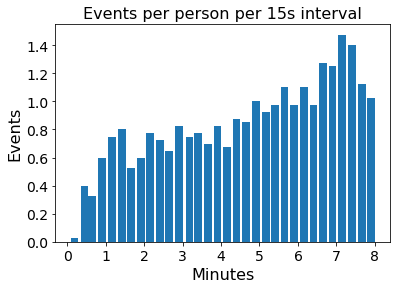

In [17]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, event) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.nodes()[player_id]['M']
        F = g.nodes()[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.nodes()[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.nodes()[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
#             assert source in game['playerIds']  # check that source is another player
#             if not g.nodes()[source]['M'].has_edge(*edge):  # check that clue is in source
#                 # this can fail if the exposer removes the clue while the exposed is dragging it.
#                 # turns out not to be a big deal
#                 print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['F'].edges()])
        assert should_have == has
       



ts = list(range(0,9*60,15))
events = 0
xs = []
events_list = []

for (player_id, g, t) in retrace(game):
    if t >= ts[0]:
        events_list.append(events)
        xs.append(t)
        ts.pop(0)
    events+=1


plt.bar(xs[1:], np.diff(events_list)/40, width=-12, align='edge')
plt.title("Events per person per 15s interval", fontsize=16)
plt.xlabel("Minutes", fontsize=16)
plt.ylabel("Events", fontsize=16)
plt.xticks(range(0, 481, 60), range(0,9), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0)